# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.

In [1]:
from PIL import Image
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:

# Define transversal Classes and Methods


def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

## Analitic solution for Oscillator
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y  = exp*2*A*cos
    return y

## Quantum model based in VQC(Variational Quantum Circuit)
dev = qml.device("default.qubit", wires = 2)

@qml.qnode(dev)
def model(x, w):
    
    qml.RX(x*w[2], wires = 0)
    qml.RX(x*w[3], wires = 1)
    
    qml.RX(w[0], wires = 0)
    qml.RX(w[1], wires = 1)
    qml.CNOT(wires = [1,0])

    #qml.RX(w[4], wires = 0)
    #qml.RX(w[5], wires = 1)
    #qml.CNOT(wires = [1,0])

    return qml.expval(qml.PauliZ(wires = 0))

# Quantum model based in VQC(Variational Quantum Circuit)
dev = qml.device("default.qubit", wires=2)


@qml.qnode(dev)
def model(x, w):
    # circuit  1
    # qml.RY(x*w[2], wires=0)
    # qml.RX(x*w[3], wires=1)
    # qml.RY(w[4], wires = 0)
    # qml.RY(w[5], wires = 1)
    # qml.CNOT(wires = [1,0])

    # circuit 2
    # qml.RY(x*w[2], wires=0)
    # qml.RX(w[0], wires=0)
    # qml.RY(w[1], wires=0)

   # circuit 3
    # qml.Hadamard(wires=0)
    # qml.Hadamard(wires = 1)
    qml.RY(x*w[0], wires=0)
    qml.RY(x*w[1], wires=1)
    qml.CNOT(wires=[1, 0])

    qml.RX(w[2], wires=0)
    qml.RY(w[3], wires=0)
    qml.CNOT(wires=[1, 0])

    qml.RX(w[4], wires=0)
    qml.RY(w[5], wires=0)
    qml.CNOT(wires=[1, 0])

    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(wires=0))

(500,) (500,)
[(tensor(0., requires_grad=True), tensor(1., requires_grad=True)), (tensor(0.04008016, requires_grad=True), tensor(0.71102225, requires_grad=True)), (tensor(0.08016032, requires_grad=True), tensor(0.06482942, requires_grad=True)), (tensor(0.12024048, requires_grad=True), tensor(-0.52211629, requires_grad=True)), (tensor(0.16032064, requires_grad=True), tensor(-0.72837541, requires_grad=True)), (tensor(0.2004008, requires_grad=True), tensor(-0.49429743, requires_grad=True)), (tensor(0.24048096, requires_grad=True), tensor(-0.01680151, requires_grad=True)), (tensor(0.28056112, requires_grad=True), tensor(0.39941576, requires_grad=True)), (tensor(0.32064128, requires_grad=True), tensor(0.52926768, requires_grad=True)), (tensor(0.36072144, requires_grad=True), tensor(0.34211867, requires_grad=True))]
(10,) (10,)


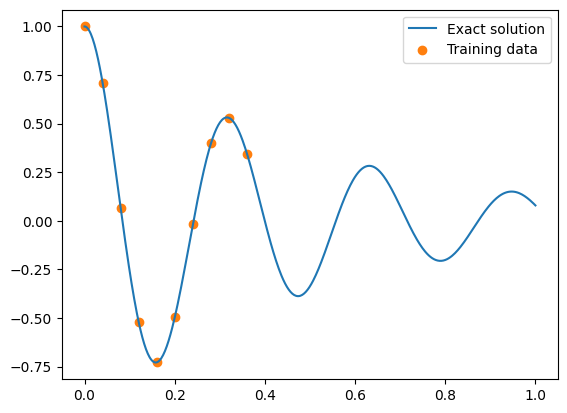

In [3]:
d, w0 = 2, 20

# Get the analytical solution over the full domain
x = np.linspace(0,1,500)
y = oscillator(d, w0, x)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
data = list(zip(x_data, y_data))
print(data)
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Normal Quantum Neural Network


epoch 100 loss 0.8801406679212138 weight [ -1.90167676  -0.13337996   1.5486437   -9.20643569 -13.82552275
   7.88877975  -4.03301667 -15.73925856]
epoch 200 loss 1.2119386018315934 weight [ -2.55409328  -0.3501049    3.4529775    2.71600917  -3.77389969
  14.26684569 -36.19807364 -23.49767325]
epoch 300 loss 1.7239472168790473 weight [ -3.04921203  -0.1133612   18.17830976  14.61145251 -29.14197394
  -8.67731429 -38.29190902 -15.24983019]
epoch 400 loss 0.4793827097662164 weight [-3.26447648e+00  2.42523731e-02  2.63707983e+01  2.75745098e+01
 -4.50136480e+01 -1.47299733e+01 -4.61079302e+01 -1.23916602e+01]
epoch 500 loss 0.47928124411045414 weight [ -3.2631254    0.08170014  26.3327535   27.53226371 -45.02657752
 -14.75838863 -46.07143286 -12.40555832]
epoch 600 loss 0.47883701454048433 weight [ -3.26728952   0.27630673  26.30993453  27.50520729 -45.03366324
 -14.77830532 -46.04563924 -12.41120315]
epoch 700 loss 0.47387241633051363 weight [ -3.31595099   0.99587765  26.21607699  27.

KeyboardInterrupt: 

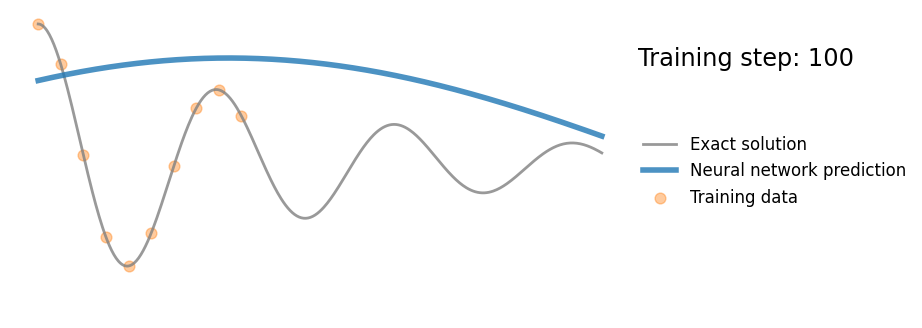

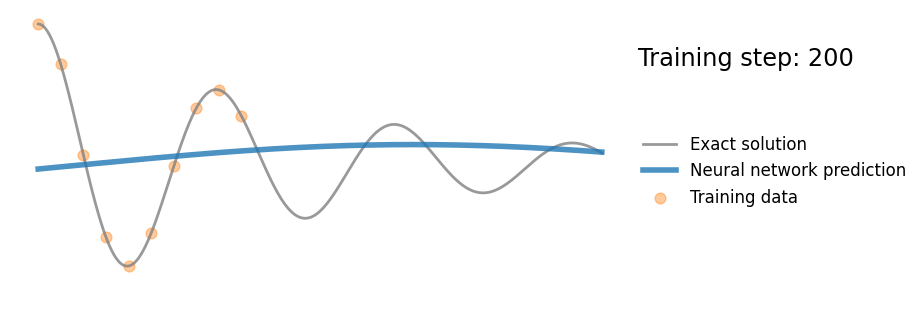

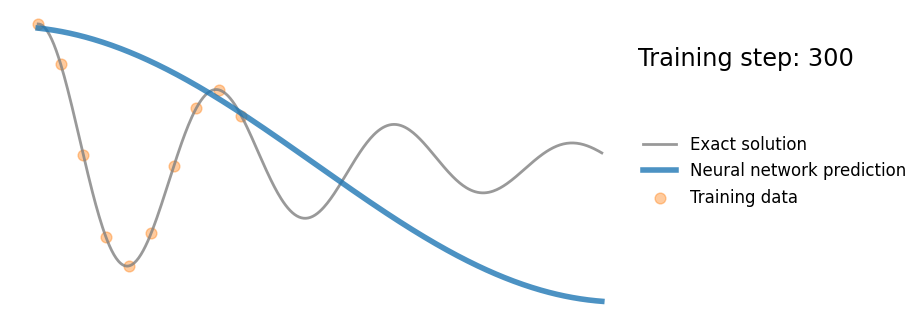

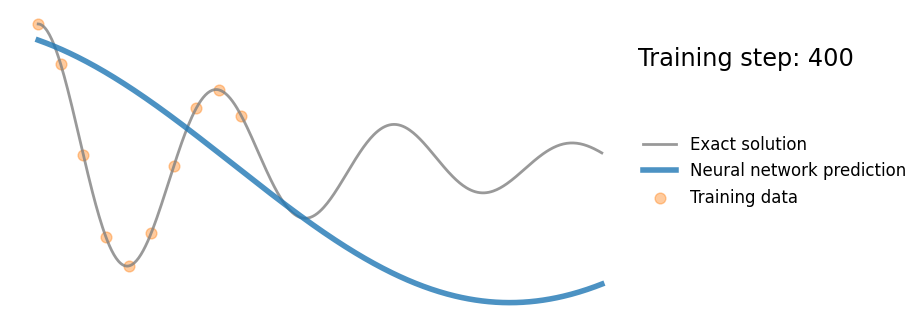

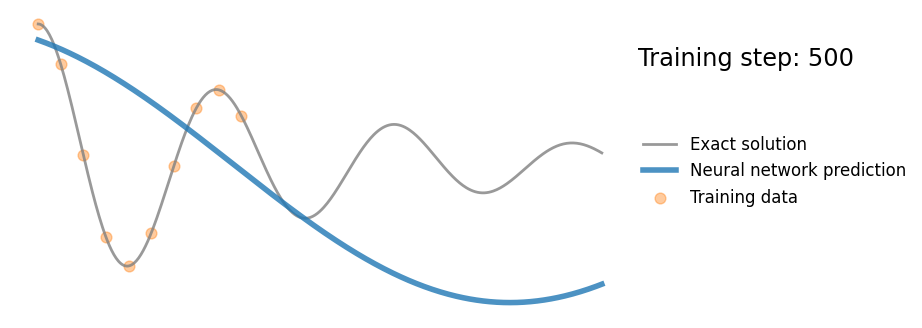

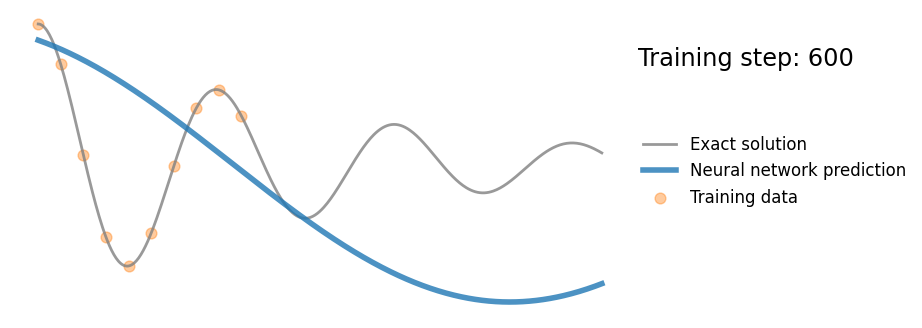

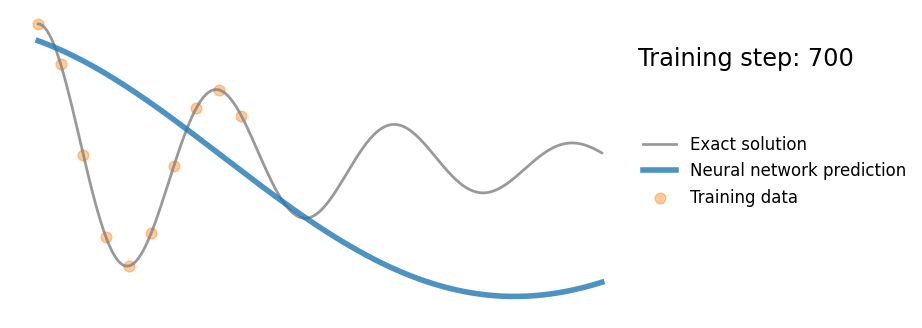

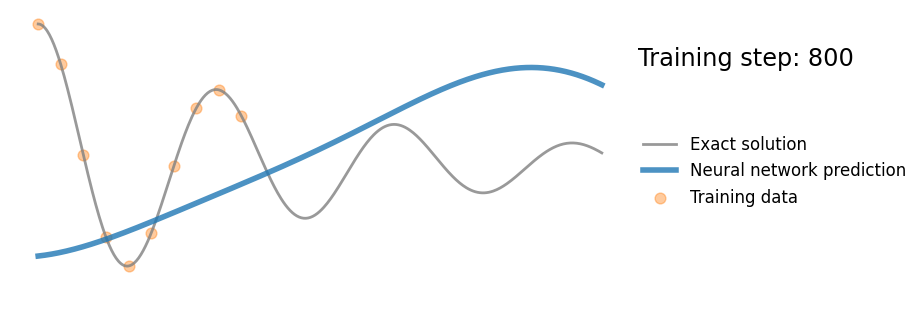

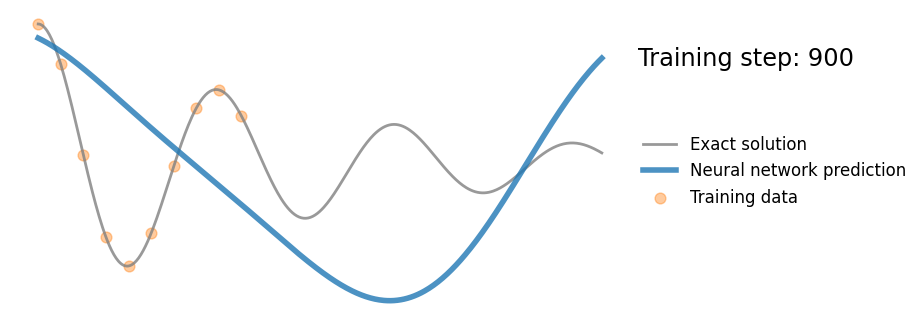

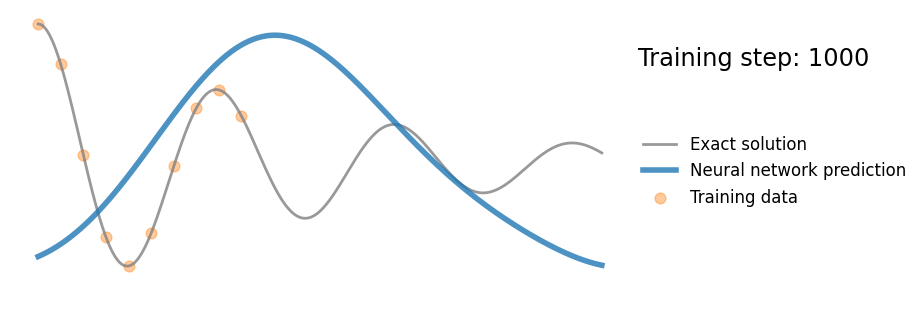

In [5]:
def plot_result(i,x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*np.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i),fontsize="xx-large",color="k")
    plt.axis("off")
    
def average_loss(w, data):
    losses = 0
    losses_ic = 0
    i = 0
    for x,y in data:
        losses += (model(x,w) - y) ** 2
        #print(qml.draw(model)(x,w))
        if  i ==0 :
            losses_ic= (model(x,w)-y)**2
        i += 1
    return losses/len(data) + losses_ic

gradient_fn_w = qml.grad(average_loss, argnum=0)

from IPython.display import clear_output
# w = np.array([-1., -0.2, 0.,0.5, -1, -0.2], requires_grad = True)
#w = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5], requires_grad = True)
w = np.array([-1., -0.2, 0.,0.5, -1, -0.2,  -0.2, -0.2], requires_grad = True)
# Inicial conditions
lr = 1.5
number_epoch = 2000
# optimizacion por método de descenso de gradiente
for epoch in range(number_epoch):
    yh =  model(x,w)
    w = w - lr*gradient_fn_w(w,data)
    if (epoch + 1) % 100 == 0:
        print("epoch", epoch + 1, "loss", average_loss(w,data), "weight",w)
        plot_result(epoch+1, x, y, x_data,y_data, yh)
       #clear_output(wait=True)

# Optimización por método de cuasi Newton BFGS
#optimize_point = optimize.minimize(average_loss, w, method = 'BFGS', jac = gradient_fn_w)
#print(optimize_point['x'])


## Physics Informed Quantum Neural Network


In [7]:
x_physics = np.linspace(0,1,30,requires_grad =True)# sample locations over the problem domain
print(x_physics)
#x_physics = np.array([-2., -0.2, 0.,0.5, -1, -0.2], requires_grad = True)
mu, k = 2*d, w0**2


def average_loss(w, data, x_physics):
    losses = 0
    losses2 = 0
    i = 0
    dx  = qml.grad(model, argnum = 0)# computes dy/dx
    dx2 = qml.grad(dx,  argnum = 0)# computes d^2y/dx^2
    for x,y in data:
        losses += (model(x,w) - y) ** 2
        #print(qml.draw(model)(x,w))
    for x_phy in x_physics :
        yhp = model(x_phy,w)
        physics = dx2(x_phy,w) + mu*dx(x_phy,w) + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
        #loss2 = (1e-4)*torch.mean(physics**2)
        losses2 += physics**2
    return losses/len(data) + 1e-4*losses2/len(x_physics)

gradient_fn_w = qml.grad(average_loss, argnum=0)

from IPython.display import clear_output
w = np.array([-1., -0.2, 0.,0.5, -1, -0.2, -0.2, -0.2], requires_grad = True)
#w = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5], requires_grad = True)

#lr = 1.5
lr = 2
# Con lr =1e-3 y 1000 epocas se demora 40 minutos
number_epoch = 1000
for epoch in range(number_epoch):
    yh =  model(x,w)
    w = w - lr*gradient_fn_w(w,data,x_physics)
    if (epoch + 1) % 100== 0:
        print("epoch", epoch+1, "loss", average_loss(w,data,x_physics), "weights",w)
        plot_result(epoch + 1, x, y, x_data,y_data, yh,x_physics)
        #clear_output(wait=True)

[0.         0.03448276 0.06896552 0.10344828 0.13793103 0.17241379
 0.20689655 0.24137931 0.27586207 0.31034483 0.34482759 0.37931034
 0.4137931  0.44827586 0.48275862 0.51724138 0.55172414 0.5862069
 0.62068966 0.65517241 0.68965517 0.72413793 0.75862069 0.79310345
 0.82758621 0.86206897 0.89655172 0.93103448 0.96551724 1.        ]
